<a href="https://colab.research.google.com/github/ShreyaVerma7/Algo/blob/master/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import math
import numpy as np
import seaborn as sns
from sklearn import preprocessing

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y.%m.%d %H:%M:%S')

In [87]:
#from google.colab import files
#uploaded = files.upload()
df_aud = pd.read_csv('AUDUSD_4 Hours_Ask_2003.08.03_2020.03.12.csv', parse_dates=['Time (UTC)'], date_parser=dateparse)

In [ ]:
#d_aud = df_aud.copy()

In [88]:
df_aud['Time (UTC)'] = pd.to_datetime(df_aud['Time (UTC)']) 
df_aud = df_aud.set_index('Time (UTC)')

In [89]:
df_aud['Volatility'] = df_aud['High']/df_aud['Low']
df_aud['Volatility'] = np.log(df_aud['Volatility'])
df_aud['Adj_Volume'] = df_aud['Volume ']/(df_aud['Volume '].rolling(10).mean())
df_aud['R_Close'] = df_aud['Close'] - df_aud['Close'].shift(1)
df_aud['R_Open'] = df_aud['Open'] - df_aud['Open'].shift(1)
df_aud['R_High'] = df_aud['High'] - df_aud['High'].shift(1)
df_aud['R_Low'] = df_aud['Low'] - df_aud['Low'].shift(1)
df_aud['H-L'] = df_aud['High'] - df_aud['Low']
df_aud['O-L'] = df_aud['Open'] - df_aud['Low']
df_aud['C-L'] = df_aud['Close']- df_aud['Low']
df_aud['H-O'] = df_aud['High'] - df_aud['Open']
df_aud['H-C'] = df_aud['High'] - df_aud['Close']
df_aud['O-C'] = df_aud['Open'] - df_aud['Close']
df_aud['(C-O)/(H-L)'] = (-df_aud['O-C']) / df_aud['H-L']
df_aud['(O-L)/(C)'] = df_aud['O-L'] / df_aud['Close']
df_aud['(O-H)/(C)'] = df_aud['H-O'] / df_aud['Close']
df_aud.dropna(inplace = True)
df_aud = df_aud.drop('Volume ',axis=1)
df_aud.head()

,Open,High,Low,Close,Volatility,Adj_Volume,R_Close,R_Open,R_High,R_Low,H-L,O-L,C-L,H-O,H-C,O-C,(C-O)/(H-L),(O-L)/(C),(O-H)/(C)
Time (UTC),,,,,,,,,,,,,,,,,,,
2003-08-05 09:00:00,0.64273,0.64366,0.64054,0.64291,0.004859,1.206673,-0.00009,-0.00431,-0.00359,-0.00143,0.00312,0.00219,0.00237,0.00093,0.00075,-0.00018,0.057692,0.003406,0.001447
2003-08-05 13:00:00,0.64295,0.64644,0.64175,0.64510,0.007282,0.738269,0.00219,0.00022,0.00278,0.00121,0.00469,0.00120,0.00335,0.00349,0.00134,-0.00215,0.458422,0.001860,0.005410
2003-08-05 17:00:00,0.64485,0.64705,0.64465,0.64635,0.003716,0.484466,0.00125,0.00190,0.00061,0.00290,0.00240,0.00020,0.00170,0.00220,0.00070,-0.00150,0.625000,0.000309,0.003404
2003-08-05 21:00:00,0.64681,0.64867,0.64526,0.64794,0.005271,0.627086,0.00159,0.00196,0.00162,0.00061,0.00341,0.00155,0.00268,0.00186,0.00073,-0.00113,0.331378,0.002392,0.002871
2003-08-06 01:00:00,0.64775,0.65062,0.64758,0.64965,0.004683,0.917345,0.00171,0.00094,0.00195,0.00232,0.00304,0.00017,0.00207,0.00287,0.00097,-0.00190,0.625000,0.000262,0.004418


In [99]:
print(df_aud.info())
print()
print(df_aud.describe())
print()
print(df_aud.median()-df_aud.mean())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25799 entries, 2003-08-05 09:00:00 to 2020-03-12 21:00:00
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         25799 non-null  float64
 1   High         25799 non-null  float64
 2   Low          25799 non-null  float64
 3   Close        25799 non-null  float64
 4   Volatility   25799 non-null  float64
 5   Adj_Volume   25799 non-null  float64
 6   R_Close      25799 non-null  float64
 7   R_Open       25799 non-null  float64
 8   R_High       25799 non-null  float64
 9   R_Low        25799 non-null  float64
 10  H-L          25799 non-null  float64
 11  O-L          25799 non-null  float64
 12  C-L          25799 non-null  float64
 13  H-O          25799 non-null  float64
 14  H-C          25799 non-null  float64
 15  O-C          25799 non-null  float64
 16  (C-O)/(H-L)  25799 non-null  float64
 17  (O-L)/(C)    25799 non-null  float64
 18  (O-H)/(C)  

In [72]:
#Test for staionarity
def test_stationarity(timeseries):
    print("Results of dickey fuller test")
    adft = adfuller(timeseries)
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_aud['R_Close'])

Results of dickey fuller test
Test Statistics                  -21.942807
p-value                            0.000000
No. of lags used                  49.000000
Number of observations used    25757.000000
critical value (1%)               -3.430604
critical value (5%)               -2.861652
critical value (10%)              -2.566830
dtype: float64


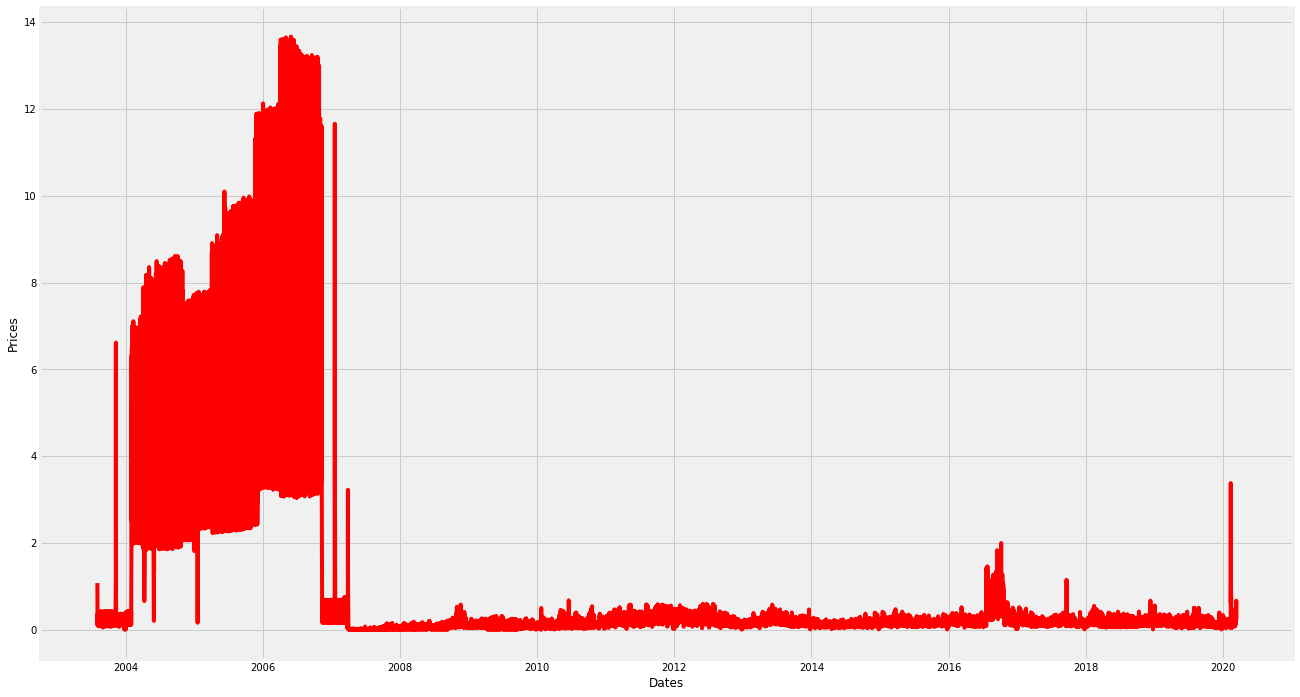

In [ ]:
plt.figure(figsize=(20,12))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Prices')
#plt.plot(df_aud['R_Close'],color='red')
#plt.plot(df_aud['Open'],color='blue')
#plt.plot(df_aud['High'],color='green')
#plt.plot(df_aud['Low'],color='black')
plt.plot(df_aud['Adj_Volume'],color='red')

plt.show()

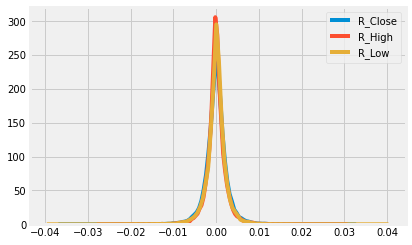

In [76]:
dist1 = sns.kdeplot(df_aud['R_Close'])
dist2 = sns.kdeplot(df_aud['R_High'])
dist3 = sns.kdeplot(df_aud['R_Low'])


<Figure size 432x288 with 0 Axes>

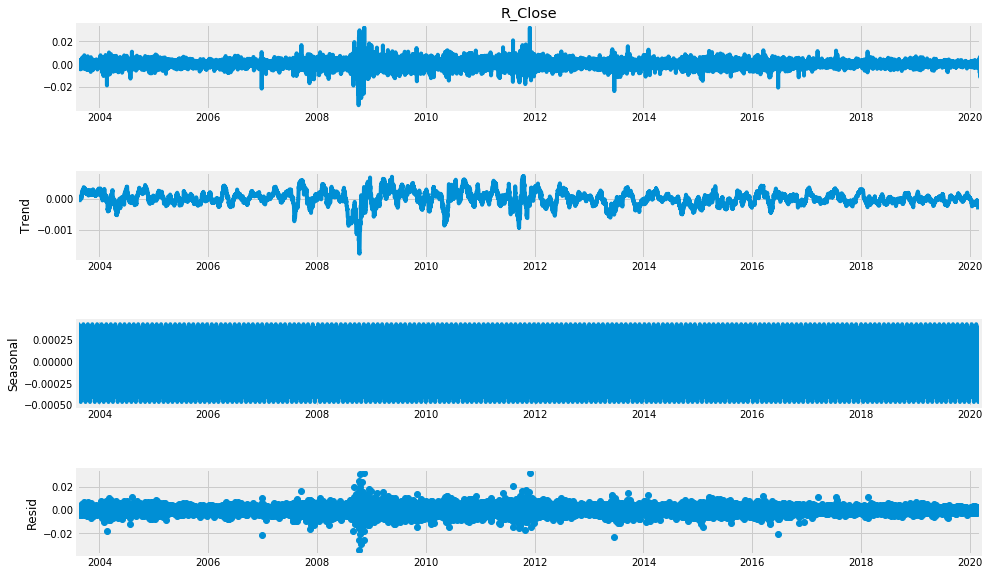

In [ ]:
result = seasonal_decompose(df_aud['R_Close'], model='additive',freq = 132)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

In [97]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [122]:
future_target = 40
past_history = 180
STEP = 6
TRAIN_SPLIT = int(0.9*len(df_aud))
dataset = df_aud.drop(['Close','High','Low'],axis=1).values
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
d_close = df_aud.Close.values

In [123]:
x_train, y_train = multivariate_data(dataset, d_close, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP)

x_test, y_test = multivariate_data(dataset, d_close,
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP)

print ('Single window of past history : {}'.format(x_train[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train[0].shape))

Single window of past history : (30, 16)

 Target temperature to predict : (40,)


In [124]:
import tensorflow
train_data_multi = tensorflow.data.Dataset.from_tensor_slices((x_train, y_train))
train_data_multi = train_data_multi.cache().shuffle(10000).batch(256).repeat()

val_data_multi = tensorflow.data.Dataset.from_tensor_slices((x_test, y_test))
val_data_multi = val_data_multi.batch(256).repeat()

In [125]:
def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        # print(type(x), type(x_temp), x.shape)
        x_temp[i] = np.reshape(x[i], (img_height, img_width))

    return x_temp

In [126]:
num_features=16
dim = int(np.sqrt(num_features))
x_train = reshape_as_image(x_train, dim, dim)
x_test = reshape_as_image(x_test, dim, dim)
#adding a 1-dim for channels (3)
#X_train = np.stack((X_train,) * 1, axis=-1)
#X_test = np.stack((X_test,) * 1, axis=-1)
#X_cv = np.stack((X_cv,) * 1, axis=-1)


ValueError: ignored

In [80]:
print("final shape of x, y train/test {} {} {} {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))


final shape of x, y train/test (16516, 16) (16516,) (5162, 16) (5162,)


In [81]:
params = {'batch_size': 80, 
          'conv2d_layers': {'conv2d_do_1': 0.25, 'conv2d_filters_1': 32, 'conv2d_kernel_size_1': 3, 
                            'conv2d_mp_1': 0, 'conv2d_strides_1': 1, 'kernel_regularizer_1': 0.0, 
                            'conv2d_do_2': 0.5, 'conv2d_filters_2': 64, 'conv2d_kernel_size_2': 3,
                            'conv2d_mp_2': 7, 'conv2d_strides_2': 1, 'kernel_regularizer_2': 0.0, 
                            'layers': 'two'},
          'dense_layers': {'dense_do_1': 0.0, 'dense_nodes_1': 128, 'kernel_regularizer_1': 0.0, 'layers': 'one'},
          'epochs': 3000, 
          'lr': 0.001, 
          'optimizer': 'adam'}

In [68]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import RandomUniform, RandomNormal
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers

def create_model_cnn(params):
    model = Sequential()

    print("Training with params {}".format(params))
    # (batch_size, timesteps, data_dim)
    # x_train, y_train = get_data_cnn(df, df.head(1).iloc[0]["timestamp"])[0:2]
    conv2d_layer1 = Conv2D(32,kernel_size=3,strides=1,activation="relu",input_shape=(4,4,1))
    model.add(conv2d_layer1)

    conv2d_layer2 = Conv2D(64,kernel_size=3,strides=1,activation="relu",input_shape=(4,4,1))
    model.add(conv2d_layer2)

    model.add(MaxPool2D(pool_size=2))

    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='softmax'))
    
    optimizer = optimizers.Adam(learning_rate=params["lr"], beta_1=0.9, beta_2=0.999, amsgrad=False)
        
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
  

In [69]:
def train_model(model, xtrain, ytrain,checkpoint,stoppoint,batch_size,epochs):    
    model.fit(xtrain, ytrain, batch_size = batch_size, epochs = epochs, validation_split= 0.3 , 
              callbacks=[checkpoint, stoppoint],verbose=1)
    return model.history

In [70]:
def plotHistory(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [71]:
m = create_model_cnn(params)
m.summary()
history = m.fit(X_train, y_train, epochs=params['epochs'], verbose=0,
                            batch_size=80, shuffle=True,
                            #validation_split=0.3,
                            #validation_data=(X_cv, y_cv),
                            #callbacks=[mcp, rlp, es]
                            #, sample_weight=sample_weights
                )
y_pred = m.predict(X_test)
print(confusion_matrix(y_test,y_pred))
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)
#print('Plot feature importances...')
#plot_importance(m, max_num_features=10)
#auc = roc_auc_score(y_test,y_pred)
#print('AUC: ', auc)

Training with params {'batch_size': 80, 'conv2d_layers': {'conv2d_do_1': 0.25, 'conv2d_filters_1': 32, 'conv2d_kernel_size_1': 3, 'conv2d_mp_1': 0, 'conv2d_strides_1': 1, 'kernel_regularizer_1': 0.0, 'conv2d_do_2': 0.5, 'conv2d_filters_2': 64, 'conv2d_kernel_size_2': 3, 'conv2d_mp_2': 7, 'conv2d_strides_2': 1, 'kernel_regularizer_2': 0.0, 'layers': 'two'}, 'dense_layers': {'dense_do_1': 0.0, 'dense_nodes_1': 128, 'kernel_regularizer_1': 0.0, 'layers': 'one'}, 'epochs': 3000, 'lr': 0.001, 'optimizer': 'adam'}
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 64)          0         
_

ValueError: ignored